In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_pdb_data = pd.read_csv('/home/lijinquan/cAMP/hemolytik-peptide.csv')
df_pdb_data.head()

,sequence,classification
0,MEIKYLLTVFLVLLIVSDHCQAFLFSLIPHAISGLISAFKGRRKRD...,1
1,MEIKYLLTVFLVLLIVSDHCQAFLFSLIPNAISGLLSAFKGRRKRN...,1
2,MMIKIAVVLCAVMATSMVFANDVKEQELADLLDLLISEEVSSPDDA...,1
3,MNFKYIIAVSFLIASAYARSEEYDIQSLSQRDVLEEESLRKIRGIG...,1
4,MAFLKKSLFLVLFLGIVSLSVCEEEKREGEEKEEKREEEEGKEENE...,1


In [3]:
from utilities.EmbeddingEncoder import EmbeddingEncoder

embed_enoder = EmbeddingEncoder()

embed_enoder.find_unique_amino_acids(df_pdb_data['sequence'])
print("Unique Amino Acid Set...")

Unique Amino Acid Set...


In [4]:
embed_enoder.create_embed_encoder()
print(embed_enoder.embed_encoder)

{'W': 0, 'K': 1, 'H': 2, 'G': 3, 'Z': 4, 'X': 5, 'C': 6, 'V': 7, 'Q': 8, 'M': 9, 'D': 10, 'I': 11, 'F': 12, 'L': 13, 'E': 14, 'T': 15, 'R': 16, 'A': 17, 'N': 18, 'P': 19, 'S': 20, 'Y': 21}


In [5]:
from utilities.DataPreProcessor import DataPreProcessor

count_dict = df_pdb_data['classification'].value_counts().to_dict()
data_pre_processor = DataPreProcessor(count_dict,embed_enoder,None)

In [6]:
## delete least preferred sequences
data_pre_processor.del_least_preferred()

df_protein_seq_final_for_modeling = df_pdb_data[df_pdb_data['classification']
        .isin(data_pre_processor.count_dict_keys_as_list())]

df_protein_seq_final_for_modeling = df_protein_seq_final_for_modeling.reset_index(drop=True)
print("final Shape of the DataSet {}".format(df_protein_seq_final_for_modeling.shape))


final Shape of the DataSet (11190, 2)


In [7]:
df_protein_seq_final_for_modeling = \
    df_protein_seq_final_for_modeling[df_protein_seq_final_for_modeling.apply(
        lambda x: len(x['sequence']) <=70 and len(x['sequence']) >=5 ,axis=1
    )]


print("final Shape of the DataSet {}".format(df_protein_seq_final_for_modeling.shape))

final Shape of the DataSet (3866, 2)


In [8]:
X_sequences = df_protein_seq_final_for_modeling['sequence']
y_label = df_protein_seq_final_for_modeling['classification']

In [9]:
## test process sequences

data_pre_processor.process_seqs_to_embeddings(X_sequences,y_label,1200)
print("Getting Processed Seqs")
print(data_pre_processor.get_x().shape)
print("getting labels")
print(data_pre_processor.get_y().shape)
# print("getting protein categories")
# print(data_pre_processor.get_protein_categoeies())


print(data_pre_processor)

Getting Processed Seqs
(3866, 1200)
getting labels
(3866, 2)


In [11]:
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import SpatialDropout1D
from keras import regularizers




In [15]:
embed_vol = 5000
embed_dim = 300
num_features = 25
max_seq_length = 1200
## AAs are supposed to be integer encoded for embedding layer 

model = Sequential()
model.add(Embedding(embed_vol,embed_dim,input_length=data_pre_processor.get_x().shape[1]))
model.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,
               recurrent_regularizer=regularizers.l2(0.02)))
model.add(LSTM(100,return_sequences=True,recurrent_regularizer=regularizers.l2(0.01)))
model.add(LSTM(100))
model.add(Dense(len(data_pre_processor.get_protein_categoeies()),activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1200, 300)         1500000   
                                                                 
 lstm_6 (LSTM)               (None, 1200, 100)         160400    
                                                                 
 lstm_7 (LSTM)               (None, 1200, 100)         80400     
                                                                 
 lstm_8 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 1,821,402
Trainable params: 1,821,402
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_pre_processor.get_x(), 
                                                    data_pre_processor.get_y(), 
                                                    test_size=0.30, random_state=42)


X_train
y_train


array([[0, 1],
       [1, 0],
       [0, 1],
       ...,
       [0, 1],
       [1, 0],
       [1, 0]], dtype=uint8)

Epoch 1/100
60/60 [==============================] - 125s 2s/step - loss: 1.9778 - accuracy: 0.4937 - val_loss: 1.0763 - val_accuracy: 0.4951
Epoch 2/100
60/60 [==============================] - 124s 2s/step - loss: 0.8653 - accuracy: 0.4937 - val_loss: 0.7483 - val_accuracy: 0.5049
Epoch 3/100
60/60 [==============================] - 125s 2s/step - loss: 0.7190 - accuracy: 0.5111 - val_loss: 0.7016 - val_accuracy: 0.5049
Epoch 4/100
60/60 [==============================] - 125s 2s/step - loss: 0.6971 - accuracy: 0.5111 - val_loss: 0.6946 - val_accuracy: 0.5049
Epoch 5/100
60/60 [==============================] - 125s 2s/step - loss: 0.6938 - accuracy: 0.5111 - val_loss: 0.6934 - val_accuracy: 0.5049
Epoch 6/100
60/60 [==============================] - 125s 2s/step - loss: 0.6931 - accuracy: 0.5111 - val_loss: 0.6932 - val_accuracy: 0.5049
Epoch 7/100
60/60 [==============================] - 126s 2s/step - loss: 0.6932 - accuracy: 0.5111 - val_loss: 0.6931 - val_accuracy: 0.5049
Epoch 

60/60 [==============================] - 135s 2s/step - loss: 0.6930 - accuracy: 0.5111 - val_loss: 0.6932 - val_accuracy: 0.5049
Epoch 59/100
60/60 [==============================] - 135s 2s/step - loss: 0.6930 - accuracy: 0.5111 - val_loss: 0.6932 - val_accuracy: 0.5049
Epoch 60/100
60/60 [==============================] - 135s 2s/step - loss: 0.6930 - accuracy: 0.5111 - val_loss: 0.6932 - val_accuracy: 0.5049
Epoch 61/100
60/60 [==============================] - 135s 2s/step - loss: 0.6930 - accuracy: 0.5111 - val_loss: 0.6932 - val_accuracy: 0.5049
Epoch 62/100
60/60 [==============================] - 135s 2s/step - loss: 0.6930 - accuracy: 0.5111 - val_loss: 0.6931 - val_accuracy: 0.5049
Epoch 63/100
60/60 [==============================] - 135s 2s/step - loss: 0.6931 - accuracy: 0.5111 - val_loss: 0.6931 - val_accuracy: 0.5049
Epoch 64/100
60/60 [==============================] - 135s 2s/step - loss: 0.6931 - accuracy: 0.5111 - val_loss: 0.6932 - val_accuracy: 0.5049
Epoch 65/100

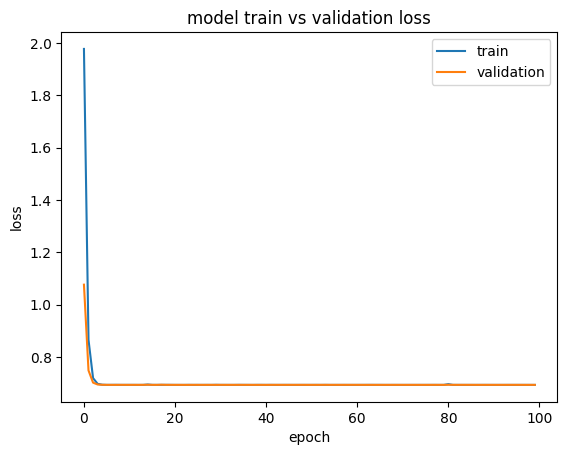

In [18]:
history = model.fit(X_train,y_train,epochs=100,verbose=1,batch_size=32,validation_split=0.3)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


In [ ]:
score,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = 32)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

